---

# InClass Kaggle Competition - Group 5 

This notebook shows the implementation of machine learning pipeline for the InClass Kaggle Competition.

Group Members:
- Charlotte Gallet
- Elina Kelly
- Hina Hussain

Submitted on: 10/04/2022

---

The machine learning pipeline includes:

1. Data processing (Part 2)
- [x] Error correction
- [x] Feature engineering
- [x] Value transformation
- [x] Value representation
- [x] Variable selection

2. Modeling (Part 3)
- [x] Benchmarking 7 models
- [x] Hyper parameter tuning

4. Interpretation (Part 3)
- [x] Learning curve
- [x] Feature Importance

In [632]:
%%time
###################################################################
# MODIFY THESE FLAGS TO TURN ON/OFF THE DATA PROCESSING FUNCTIONS #
###################################################################

# Flag variables to run the data processing steps
# Feature engineering step
enable_num_poly = True  # Add polynomial terms
# Value transformation step
enable_trans_cat_dt = True  # Remapping cat variables - Decision tree–based remapping
enable_trans_num_dt = True  # Discretizing num variables - Decision tree–based discretization
#enable_trans_num_ef = True  # Discretizing num variables - Equal frequency discretization
#enable_trans_num_ew = True  # Discretizing num variables - Equal width discretization
# Value representation step
enable_repr_dummy = True  # Represent cat variables - Dummy coding
#enable_repr_icd = True  # Represent cat variables - Incidence (of target variable) replacement
#enable_repr_woe = True  # Represent cat variables - Weight-of-Evidence (WoE) conversion
drop_cat_vars = True  # Drop cat variables after value representation step
# Other data processing
#enable_normalize = True  # Normalize the data to the same range [0, 1]

Wall time: 0 ns


## Initiation

In [633]:
%%time
# Data exploration
import matplotlib.pyplot as plt

# Data processing
import pickle
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

# Experimental setup
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, GridSearchCV
#from imblearn.over_sampling import SMOTE, RandomOverSampler
#from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, train_test_split

Wall time: 2 ms


## 1. Data summary

#### (a) Read and print out some data

In [634]:
%%time
# Read train, test
train = pd.read_csv("C:/Users/hhussain1/Desktop/SML/Group Project/Data/bank_mkt_train.csv", low_memory=False)
test = pd.read_csv("C:/Users/hhussain1/Desktop/SML/Group Project/Data/bank_mkt_test.csv", low_memory=False)




Wall time: 241 ms


In [635]:
%%time
# Print out to check the data
print(train.dtypes.value_counts())
train.head()

object     10
float64     9
int64       2
dtype: int64
Wall time: 7 ms


,client_id,age,job,marital,education,default,housing,loan,contact,month,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,subscribe
0,29925,42.0,management,married,basic.9y,no,no,no,cellular,jul,...,1.0,999.0,0.0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,0
1,37529,35.0,unemployed,married,university.degree,no,yes,no,telephone,jun,...,4.0,999.0,0.0,nonexistent,1.4,94.465,-41.8,4.960,5228.1,0
2,2757,44.0,technician,married,basic.9y,no,yes,yes,cellular,may,...,1.0,999.0,0.0,nonexistent,-1.8,92.893,-46.2,1.264,5099.1,0
3,9642,45.0,services,married,high.school,no,yes,no,cellular,apr,...,1.0,999.0,0.0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,0
4,14183,45.0,unknown,married,unknown,unknown,unknown,unknown,telephone,may,...,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0


#### (b) Create a list of column names to manage variables

In [636]:
%%time
# General list of variables
id_var = ["client_id"]  # ID
target_var = ["subscribe"]  # Target get variable
predictors = [v for v in train.columns if v not in id_var + target_var]

# List of numerical and catergorical variables
num_vars = ['age', 'campaign', 'pdays', 'previous',
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan',
            'contact', 'month', 'day_of_week',
            'poutcome']

# Double check the list of variables
assert(len(predictors) == len(num_vars) + len(cat_vars))

Wall time: 0 ns


#### (c) Check the target variable class distribution

In [637]:
%%time
# By number
print(train[target_var].value_counts())

# By percentage
print(train[target_var].value_counts(normalize=True))

subscribe
0            17729
1             2271
dtype: int64
subscribe
0            0.88645
1            0.11355
dtype: float64
Wall time: 13 ms


#### (d) Creating a validation set

In [638]:
#Split the train set into train and validation

X_train, X_val, y_train, y_val = train_test_split(train[train.columns[~train.columns.isin(['subscribe'])]], train["subscribe"], test_size=0.2, stratify = train["subscribe"], random_state=42)

In [639]:
#Create final validation set with IV and DV
validation = X_val
validation["subscribe"] = y_val

In [640]:
#Create final train set
train = X_train
train["subscribe"] = y_train

In [641]:
#Reset index

train = train.reset_index(drop=True)
validation = validation.reset_index(drop=True)

In [642]:
#Check dimensions
print(train.shape)
print(validation.shape)
print(test.shape)

(16000, 21)
(4000, 21)
(10000, 20)


## 2. Processing data

### 2.1. Error, data correction

#### (a) Check and correct data error - Constant variables

Constant variables on train do not contain information and may cause data processing or model training error.

In [643]:
%%time
# Count number of unique values of each variable
vars_nunique = train[num_vars + cat_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()
print("Drop constant variable:", cont_vars)

# Correct variable list
num_vars = [v for v in num_vars if v not in cont_vars]
cat_vars = [v for v in cat_vars if v not in cont_vars]

# Update train, validation, test
train = train[id_var + num_vars + cat_vars + target_var]
validation = validation[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop constant variable: []
Wall time: 40 ms


#### (b) Check and correct data error - Missing values

In [644]:
%%time
# Check missing value
print('Train - # NA of num vars:', train[num_vars].isna().sum().sum())
print('Train - # NA of cat vars:', train[cat_vars].isna().sum().sum())
print('Validation - # NA of num vars:', validation[num_vars].isna().sum().sum())
print('Validation - # NA of cat vars:', validation[cat_vars].isna().sum().sum())
print('Test - # NA of num vars:', test[num_vars].isna().sum().sum())
print('Test - # NA of cat vars:', test[cat_vars].isna().sum().sum())

Train - # NA of num vars: 1378
Train - # NA of cat vars: 1531
Validation - # NA of num vars: 352
Validation - # NA of cat vars: 403
Test - # NA of num vars: 918
Test - # NA of cat vars: 1057
Wall time: 26 ms


In [645]:
%%time
# Here, we test the effect of dropping variables with high missing percentage (>30%)
na_threshold = 0.3

# Drop num variables with more than 30% missing values
num_na_pct = train[num_vars].isnull().mean()
num_vars = num_na_pct[num_na_pct <= na_threshold].index.tolist()
print("Drop num variables with high missing pct:", num_na_pct[num_na_pct > na_threshold].tolist())

# Drop cat variables with more than 30% missing values
cat_na_pct = train[cat_vars].isnull().mean()
cat_vars = cat_na_pct[cat_na_pct <= 0.3].index.tolist()
print("Drop cat variables with high missing pct:", cat_na_pct[cat_na_pct > na_threshold].tolist())

# Update train, test
train = train[id_var + num_vars + cat_vars + target_var]
validation = validation[id_var + num_vars + cat_vars + target_var]
test = test[id_var + num_vars + cat_vars]

Drop num variables with high missing pct: []
Drop cat variables with high missing pct: []
Wall time: 21 ms


In [646]:
%%time
# List summary variables to track missing values imputation
na_vars = []

Wall time: 0 ns


In [647]:
%%time
# Numerical variables
# Build the missing value imputor using the mean
imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(train[num_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [num_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = num_vars + na_vars

# Apply on train, validation, test
train[impute_vars] = pd.DataFrame(imp.transform(train[num_vars]), columns=impute_vars)
validation[impute_vars] = pd.DataFrame(imp.transform(validation[num_vars]), columns=impute_vars)
test[impute_vars] = pd.DataFrame(imp.transform(test[num_vars]), columns=impute_vars)

Wall time: 48.1 ms


In [648]:
train.head(2)

,client_id,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,subscribe,age_na,campaign_na,pdays_na,previous_na,emp.var.rate_na,cons.price.idx_na,cons.conf.idx_na,euribor3m_na,nr.employed_na
0,21641,36.0,2.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,35922,26.0,1.0,999.0,0.0,1.4,94.465,-41.8,4.962,5228.1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [649]:
%%time
# Categorical variables
# Impute missing value using a new category "Missing"
# Note: If the categorical vars are imputed by most_frequent, the indicators should be added
train[cat_vars] = train[cat_vars].fillna('Missing')
validation[cat_vars] = validation[cat_vars].fillna('Missing')
test[cat_vars] = test[cat_vars].fillna('Missing')

Wall time: 33 ms


#### (c) Check and correct data error - Outliers in numerical variables


In [650]:
%%time
# Check the outliers on train, validation, test
for v in num_vars:
    # Calculate the boundaries on train [mean-3*sd, mean+3*sd]
    mu = np.mean(train[v])
    sd = np.std(train[v])
    lower = mu - 3*sd
    upper = mu + 3*sd
    # Check outliers using the boundaries
    train_out = (train[v] < lower) | (train[v] > upper)
    validation_out = (validation[v] < lower) | (validation[v] > upper)
    test_out = (test[v] < lower) | (test[v] > upper)
    if np.sum(train_out) + np.sum(validation_out) +  np.sum(test_out) > 0:
        print(v, "has # outliers on train, validation, test :",
              np.sum(train_out), "[", np.round(100*np.mean(train_out), 2), "% ]",
              np.sum(validation_out), "[", np.round(100*np.mean(validation_out), 2), "% ]",
              np.sum(test_out), "[", np.round(100*np.mean(test_out), 2), "% ]")

age has # outliers on train, validation, test : 144 [ 0.9 % ] 37 [ 0.92 % ] 89 [ 0.89 % ]
campaign has # outliers on train, validation, test : 341 [ 2.13 % ] 82 [ 2.05 % ] 210 [ 2.1 % ]
pdays has # outliers on train, validation, test : 596 [ 3.72 % ] 154 [ 3.85 % ] 371 [ 3.71 % ]
previous has # outliers on train, validation, test : 416 [ 2.6 % ] 103 [ 2.58 % ] 269 [ 2.69 % ]
Wall time: 32 ms


<u>Looking at the context of the outliers, it was decided not to treat them.</u>

- Maximum age is 98 and minimum age is 17 which is realistic and does not seem to be an error 
- The same is true for the campaign variable that the values seem realistic
- pdays shows an outlier because the number 999 shows that a client was never contacted
- The values in the previous column are also realistic and do not require adjustment

#### (d) Encode categorical variables



In [651]:
%%time
# Encode categorical variables as integer values
# Categorical variables in any format will be converted to string
# Note: All the NA values were imputed previously
enc = OrdinalEncoder()
enc.fit(pd.concat([train[cat_vars].astype(str), test[cat_vars].astype(str), validation[cat_vars].astype(str)], axis=0))
# Apply on train, validation, test
train[cat_vars] = enc.transform(train[cat_vars].astype(str))
validation[cat_vars] = enc.transform(validation[cat_vars].astype(str))
test[cat_vars] = enc.transform(test[cat_vars].astype(str))

Wall time: 177 ms


#### (e) Finalize the processed data

Current lists of variables:
- id_var : customer ID
- num_vars : numerical variables
- cat_vars : categorical variables
- na_vars : indicators for tracking missing values, bool [False, True]
- target_var : target variable, subscribe [0, 1]



In [652]:
%%time
# Convert bool variable to int
train[na_vars] = train[na_vars].astype(np.int8)
validation[na_vars] = validation[na_vars].astype(np.int8)
test[na_vars] = test[na_vars].astype(np.int8)

Wall time: 79.8 ms


In [653]:
%%time
# Print out the final variables
print("# id_var [", len(id_var), "] :", id_var)
print("# num_vars [", len(num_vars), "] :", num_vars[:5], "...")
print("# cat_vars [", len(cat_vars), "] :", cat_vars[:5], "...")
print("# na_vars [", len(na_vars), "] :", na_vars[:5], "...")
print("# target_var [", len(target_var), "] :", target_var)

# id_var [ 1 ] : ['client_id']
# num_vars [ 9 ] : ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate'] ...
# cat_vars [ 10 ] : ['job', 'marital', 'education', 'default', 'housing'] ...
# na_vars [ 9 ] : ['age_na', 'campaign_na', 'pdays_na', 'previous_na', 'emp.var.rate_na'] ...
# target_var [ 1 ] : ['subscribe']
Wall time: 4 ms


In [654]:
%%time
# Sort the data according to the variables list
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
validation = validation[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(validation.shape)
print(test.shape)

(16000, 30)
(4000, 30)
(10000, 29)
Wall time: 8.02 ms


### 2.2. Feature engineering



#### (a) Quickly detect most (potentially) important varriables - Correlation test for numerical variables

In [655]:
%%time
# Pearson's correlation for numerical variables
corr = train[num_vars + target_var].corr(method='pearson')
corr = corr[target_var[0]][:-1].dropna().sort_values(ascending=False)
print("Top 5 vars [+] correlated with target_var :"); print(corr[corr > 0][:5])
print("")
print("Top 5 vars [-] correlated with target_var :"); print(corr[corr < 0][-5:])

Top 5 vars [+] correlated with target_var :
previous         0.240116
cons.conf.idx    0.052099
age              0.034763
Name: subscribe, dtype: float64

Top 5 vars [-] correlated with target_var :
cons.price.idx   -0.132582
emp.var.rate     -0.299465
euribor3m        -0.310996
pdays            -0.335399
nr.employed      -0.360334
Name: subscribe, dtype: float64
Wall time: 12 ms


#### (b) Add polynomial terms for numerical variables

<u>Note:</u> We only add the polynomial terms (degree=3) for a num variable if it increases the LR model performance.

In [656]:
%%time
if enable_num_poly:
    for v in num_vars:
        # Setup the LR model
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = LogisticRegression(max_iter=200)
        parameters = {}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        
        # Fit the LR model for 1 numerical variable
        clf.fit(train[[v]], train[target_var].squeeze())
        clf_num_score = clf.best_score_
        
        # Fit the LR model for 1 numerical variable + it polynomial degree = 3
        poly = PolynomialFeatures(degree=3, include_bias=False)
        poly.fit(train[[v]])
        clf.fit(poly.transform(train[[v]]), train[target_var].squeeze())
        clf_poly_score = clf.best_score_
        
        # Add the polynomial terms to train, validation test
        if (clf_poly_score > 0.5) & (clf_poly_score - clf_num_score > 0.05):
            print('Variable', v, 'AUC vs. AUC poly:', clf_num_score, '-->', clf_poly_score)
            poly_vars = [v_poly.replace('x0', v) for v_poly in poly.get_feature_names()[1:]]
            num_vars = num_vars + poly_vars
            train[poly_vars] = pd.DataFrame(poly.transform(train[[v]])[:, 1:], columns=poly_vars)
            validation[poly_vars] = pd.DataFrame(poly.transform(validation[[v]])[:, 1:], columns=poly_vars)            
            test[poly_vars] = pd.DataFrame(poly.transform(test[[v]])[:, 1:], columns=poly_vars)

Variable age AUC vs. AUC poly: 0.49143272622017353 --> 0.6007377603416612


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Wall time: 3.74 s


### 2.3. Value transformation (num, cat => cat)

- Categorical variable: remapping
- Continuous variable: discretization


<u>Reference:</u>

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [657]:
%%time
# List of variables to track the value transformation process
trans_vars = []

Wall time: 0 ns


#### 2.3.1. Remapping categorical variables - Decision tree–based remapping

#### (a) Apply the variable remmaping for all categorical variables

<u>Note:</u> Only remap the variables if AUC > 0.5 and the number of new categories > 1.

In [658]:
%%time
if enable_trans_cat_dt:
    for v in cat_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, validation, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Remapping variable", v,
                  "from", train[[v]].nunique().values[0],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_remap'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            validation[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(validation[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Remapping variable job from 13 to 11 categories
Remapping variable marital from 5 to 3 categories
Remapping variable education from 9 to 6 categories
Remapping variable default from 4 to 3 categories
Remapping variable housing from 4 to 2 categories
Remapping variable contact from 3 to 3 categories
Remapping variable month from 11 to 10 categories
Remapping variable day_of_week from 6 to 2 categories
Remapping variable poutcome from 4 to 3 categories
Wall time: 2.38 s


#### 2.3.2. Discretizing (or binning) numerical variables - Decision tree–based discretization

#### (a) Apply the variable discretizing for all numerical variables

<u>Note:</u> Only bin/discretize the variables if the number of new categories > 1.

In [660]:
%%time
if enable_trans_num_dt:
    for v in num_vars:
        # Find the best decision tree using CV
        cv = KFold(n_splits=5, random_state=1, shuffle=True)
        model = DecisionTreeClassifier()
        parameters = {'min_samples_leaf':(train.shape[0]*np.array([0.01, 0.025, 0.05, 0.1, 0.25, 0.5])).astype(int)}
        clf = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=0)
        clf.fit(train[[v]], train[target_var])
        # Remap the variable on train, validation, test
        if (clf.best_score_ > 0.5) & (clf.best_estimator_.get_n_leaves() > 1):
            print("Discretize variable", v,
                  "from", [train[[v]].min().values[0], train[[v]].max().values[0]],
                  "to", clf.best_estimator_.get_n_leaves(), "categories")
            remap_var = v + '_bin'
            trans_vars.append(remap_var)
            train[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(train[[v]]).toarray()]
            validation[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(validation[[v]]).toarray()]
            test[remap_var] = [np.nonzero(r)[0].max() for r in clf.best_estimator_.decision_path(test[[v]]).toarray()]

Discretize variable age from [18.0, 95.0] to 39 categories
Discretize variable campaign from [1.0, 56.0] to 7 categories
Discretize variable pdays from [0.0, 999.0] to 3 categories
Discretize variable previous from [0.0, 6.0] to 4 categories
Discretize variable emp.var.rate from [-3.4, 1.4] to 8 categories
Discretize variable cons.price.idx from [92.201, 94.767] to 14 categories
Discretize variable cons.conf.idx from [-50.8, -26.9] to 15 categories
Discretize variable euribor3m from [0.634, 5.045] to 47 categories
Discretize variable nr.employed from [4963.6, 5228.1] to 9 categories
Discretize variable age^2 from [324.0, 9025.0] to 39 categories
Discretize variable age^3 from [5832.0, 857375.0] to 39 categories
Wall time: 2.94 s


#### 2.3.3. Finalize value transformation

- Finalize the variables list
- Arrange the data columns

<u>Note:</u> After the end of the value transformation step, we have these final lists of variables to manage:
- num_vars
- na_vars
- cat_vars = cat_vars + trans_vars

In [661]:
%%time
# Finalize the variable list
cat_vars = cat_vars + trans_vars
print("Transformed num, cat variables into # new categorical variables :", len(trans_vars))

Transformed num, cat variables into # new categorical variables : 20
Wall time: 0 ns


In [662]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
validation = validation[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(validation.shape)
print(test.shape)

(16000, 52)
(4000, 52)
(10000, 51)
Wall time: 32.5 ms


In [663]:
train.isna().sum().sum()

0

In [664]:
validation.isna().sum().sum()

0

In [665]:
test.isna().sum().sum()

0

### 2.4. Value representation (cat => num)

- Categorical variable: Dummy coding

<u>Reference:</u>  

- Coussement, K., Lessmann, S., & Verstraeten, G. (2017). A comparative analysis of data preparation algorithms for customer churn prediction: A case study in the telecommunication industry. Decision Support Systems, 95, 27-36.

In [666]:
%%time
# List of variables to track the value representation process
repr_vars = []
dummy_vars = []

Wall time: 0 ns


#### 2.4.1. Dummy coding

<u>Note:</u> Here, we can fit the encoder on both train and test to make sure it captures all unique categories.

#### (a) Apply the value representation for all categorical variables

In [667]:
%%time

if enable_repr_dummy:
    # Create dummy variables, drop the first dummy column
    enc = OneHotEncoder(drop="first", handle_unknown="error")
    enc.fit(pd.concat([train[cat_vars], validation[cat_vars],  test[cat_vars]], axis=0))
    dummy_vars = enc.get_feature_names_out().tolist()
    repr_vars = repr_vars + dummy_vars
    # Transform train, validation test
    train_dummy = enc.transform(train[cat_vars])
    validation_dummy = enc.transform(validation[cat_vars])    
    test_dummy = enc.transform(test[cat_vars])

Wall time: 145 ms


#### 2.4.2. Finalize value representation 

#### (a) Drop categorical variables, add dummy variables

At the end of this step, all categorical variables were represented by dummy variables or numerical variables. Therefore, it is no need to keep categorical variables.

In [668]:
%%time
# Drop cat vars
if drop_cat_vars:
    train = train.drop(cat_vars, axis=1)
    validation = validation.drop(cat_vars, axis=1)
    test = test.drop(cat_vars, axis=1)
    cat_vars = []

Wall time: 3.99 ms


In [669]:
%%time
# Add dummy variables
if enable_repr_dummy:
    train = pd.concat([train, pd.DataFrame(train_dummy.toarray(), columns=dummy_vars)], axis=1)
    validation = pd.concat([validation, pd.DataFrame(validation_dummy.toarray(), columns=dummy_vars)], axis=1)
    test = pd.concat([test, pd.DataFrame(test_dummy.toarray(), columns=dummy_vars)], axis=1)
    del train_dummy, test_dummy

Wall time: 108 ms


In [670]:
train.isna().sum().sum()

0

In [671]:
validation.isna().sum().sum()

0

In [672]:
test.isna().sum().sum()

0

#### (b) Finalize the variables list

<u>Note:</u> At the end of the value representation step, we have these final lists of variables to manage:
- num_vars = num_vars + repr_vars
- na_vars

In [673]:
%%time
# Combine the variable list
num_vars = num_vars + repr_vars
print("Represented cat variables with # new num variables :", len(repr_vars))

Represented cat variables with # new num variables : 300
Wall time: 997 µs


In [674]:
%%time
# Arrange the data columns
train = train[id_var + num_vars + cat_vars + na_vars + target_var]
validation = validation[id_var + num_vars + cat_vars + na_vars + target_var]
test = test[id_var + num_vars + cat_vars + na_vars]
print(train.shape)
print(validation.shape)
print(test.shape)

(16000, 322)
(4000, 322)
(10000, 321)
Wall time: 93.9 ms


### 2.5. Other data processing

####  (a) Filter out low variance variables (or constant)

During the data processing, we may accidentally create some new constant variables. Therefore, it is necessary to filter again.

In [675]:
%%time
# List of all predictors
predictors = num_vars + cat_vars + na_vars

Wall time: 0 ns


In [676]:
%%time
# Detect constant vars
sel = VarianceThreshold(0)  # Var = 0 by default
sel.fit(train[predictors])
const_vars = [predictors[i] for i in np.where(sel.variances_ == 0)[0]]
predictors = [v for v in predictors if v not in const_vars]

# Drop from train, validation, test
print('Drop # constant vars :', len(const_vars))
train = train.drop(const_vars, axis=1)
validation = validation.drop(const_vars, axis=1)
test = test.drop(const_vars, axis=1)

Drop # constant vars : 0
Wall time: 142 ms


#### (b) Drop duplicated variables

Sometime, the data processing process can create a lot of duplicated variables. In this case, it is necessary to identify and drop them.

In [677]:
%%time
# Count the duplicated vars
dup_vars = train[predictors].T.duplicated()
print('# duplicated vars :', dup_vars.sum())

# duplicated vars : 104
Wall time: 3.16 s


In [678]:
%%time
# Drop the duplicated vars from train, validation, test
predictors = [predictors[i] for i in range(0, len(predictors)) if not dup_vars[i]]
train = train[id_var + predictors + target_var]
validation = validation[id_var + predictors + target_var]
test = test[id_var + predictors]

Wall time: 27 ms


#### (c) Export the processed data to file

In [679]:
%%time
# Print out the data to check
print(train.shape)
print(validation.shape)
print(test.shape)

(16000, 218)
(4000, 218)
(10000, 217)
Wall time: 1.05 ms


In [680]:
%%time
# Save to pickle format
train.to_pickle("C:/Users/hhussain1/Desktop/SML/Group Project/Pickles/train_processed.pkl")
validation.to_pickle("C:/Users/hhussain1/Desktop/SML/Group Project/Pickles/validation_processed.pkl")
test.to_pickle("C:/Users/hhussain1/Desktop/SML/Group Project/Pickles/test_processed.pkl")

Wall time: 28 ms


In [703]:
#Save to CSV for submission

train.to_csv("C:/Users/hhussain1/Desktop/SML/Group Project/train.csv", index = False)
validation.to_csv("C:/Users/hhussain1/Desktop/SML/Group Project/validation.csv", index = False)
test.to_csv("C:/Users/hhussain1/Desktop/SML/Group Project/test.csv", index = False)

### 2.6. Variable selection

<u>Reference:</u>  

- Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights into churn prediction in the telecommunication sector: A profit driven data mining approach. European Journal of Operational Research, 218(1), 211-229.

In [681]:
%%time
# Read back the processed data
train = pd.read_pickle("C:/Users/hhussain1/Desktop/SML/Group Project/Pickles/train_processed.pkl")
validation = pd.read_pickle("C:/Users/hhussain1/Desktop/SML/Group Project/Pickles/validation_processed.pkl")
test = pd.read_pickle("C:/Users/hhussain1/Desktop/SML/Group Project/Pickles/test_processed.pkl")

Wall time: 42 ms


In [682]:
%%time
# Create several lists to handle variables
id_var = ['client_id']
target_var = ['subscribe']
predictors = [v for v in train.columns if v not in id_var + target_var]

Wall time: 0 ns


####  Variable selection: Fisher Score

In [683]:
%%time
def FisherScore(bt, target_var, predictors):
    """
    This function calculate the Fisher score of a variable.

    Ref:
    ---
    Verbeke, W., Dejaeger, K., Martens, D., Hur, J., & Baesens, B. (2012). New insights
    into churn prediction in the telecommunication sector: A profit driven data mining
    approach. European Journal of Operational Research, 218(1), 211-229.
    """
    
    # Get the unique values of dependent variable
    target_var_val = bt[target_var].unique()
    # Calculate FisherScore for each predictor
    predictor_FisherScore = []
    for v in predictors:
        fs = np.abs(np.mean(bt.loc[bt[target_var]==target_var_val[0], v]) - np.mean(bt.loc[bt[target_var]==target_var_val[1], v])) / \
             np.sqrt(np.var(bt.loc[bt[target_var]==target_var_val[0], v]) + np.var(bt.loc[bt[target_var]==target_var_val[1], v]))
        predictor_FisherScore.append(fs)
    return predictor_FisherScore

Wall time: 0 ns


In [684]:
%%time
# Calculate Fisher Score for all variable
fs = FisherScore(train, target_var[0], predictors)
fs_df = pd.DataFrame({"predictor":predictors, "fisherscore":fs})
fs_df = fs_df.sort_values('fisherscore', ascending=False)
fs_df.head()

Wall time: 440 ms


,predictor,fisherscore
8,nr.employed,0.747921
7,euribor3m,0.706608
4,emp.var.rate,0.670617
2,pdays,0.468189
116,pdays_bin_4,0.467943


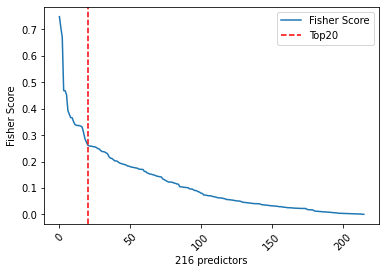

Wall time: 168 ms


In [685]:
%%time
# Visualize the Fisher Score
plt.plot(fs_df['fisherscore'].values.squeeze())
plt.axvline(x=20, linestyle='dashed', color='red')
plt.xticks(rotation=45)
plt.xlabel(str(fs_df.shape[0]) + ' predictors')
plt.ylabel('Fisher Score')
plt.legend(['Fisher Score', 'Top20'])
plt.show()

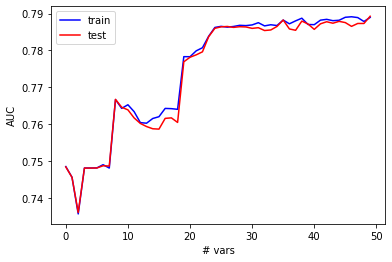

Wall time: 20.7 s


In [686]:
%%time
# Check how AUC change when add more variables: Top n vars
fs_scores = []
top_n_vars = 50
for i in range(1, top_n_vars+1):
    if i % 100 == 0: print('Added # top vars :', i)
    top_n_predictors = fs_df['predictor'][:i]
    clf = LogisticRegression()
    fs_scores.append(cross_validate(clf, train[top_n_predictors], train[target_var].values.squeeze(),
                                    scoring='roc_auc', cv=5, verbose=0, n_jobs=-1, return_train_score=True))

# How the AUC curve looks like when adding top vars
plt.plot([s['train_score'].mean() for s in fs_scores], color='blue')
plt.plot([s['test_score'].mean() for s in fs_scores], color='red')
plt.xlabel('# vars')
plt.ylabel('AUC')
plt.legend(['train', 'test'])
plt.show()

In [687]:
%%time
# Select the top variables based on Fisher Score
n_top_fs_vars = 50  # Top FS vars
top_fs_vars = fs_df['predictor'].values[:n_top_fs_vars]
print("Selected # vars :", len(top_fs_vars))
top_fs_vars

Selected # vars : 50
Wall time: 0 ns


array(['nr.employed', 'euribor3m', 'emp.var.rate', 'pdays', 'pdays_bin_4',
       'poutcome_3.0', 'previous', 'poutcome_2.0', 'emp.var.rate_bin_14',
       'nr.employed_bin_16', 'pdays_bin_3', 'cons.price.idx_bin_21',
       'contact_2.0', 'nr.employed_bin_13', 'emp.var.rate_bin_13',
       'cons.conf.idx_bin_20', 'contact_1.0', 'previous_bin_6',
       'nr.employed_bin_8', 'cons.price.idx', 'cons.conf.idx_bin_23',
       'nr.employed_bin_9', 'emp.var.rate_bin_5', 'month_7.0',
       'default_remap_4', 'default_2.0', 'emp.var.rate_bin_8',
       'nr.employed_bin_6', 'nr.employed_bin_7', 'cons.price.idx_bin_25',
       'cons.conf.idx_bin_18', 'cons.price.idx_bin_5', 'default_1.0',
       'cons.conf.idx_bin_17', 'emp.var.rate_bin_9', 'previous_bin_5',
       'month_9.0', 'cons.price.idx_bin_4', 'euribor3m_bin_60',
       'cons.conf.idx_bin_27', 'month_10.0', 'month_6.0',
       'euribor3m_bin_7', 'cons.price.idx_bin_17', 'age_bin_76',
       'euribor3m_bin_4', 'cons.conf.idx_bin_21', 'eu

In [688]:
print(train.shape)
print(validation.shape)
print(test.shape)

(16000, 218)
(4000, 218)
(10000, 217)


## 3. Modeling



In [689]:
%%time

#Subset the train, validation, and test sets to keep only the features selected through the fisher score

X_train = train[top_fs_vars]
X_validation = validation[top_fs_vars]
X_test = test[top_fs_vars]
X_full = pd.concat([X_train, X_validation], axis=0)

test_id = test[id_var]


y_train = train[target_var]
y_validation = validation[target_var]
y_full = pd.concat([y_train, y_validation], axis=0)

Wall time: 19 ms


### 3.1. Modeling Benchmark

In [690]:
# Instanciate the models

tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [691]:
models = {"Decision Tree"         :tree,
          "Logistic Regression"     :logistic,
          "Random Forest" :randomForest,
          "Boosted Tree"  :boostedTree,
          "SVM"          :svm,
          "NeuralNet"    :neuralNet,
          "KNN"    :neighbors
         }

In [692]:
#Train the models on the train set

for model in models:
    models[model].fit(X_train, y_train.values.ravel())
    


In [693]:
#Predict on the train and validation to evaluate and compare

performances = {}

for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}

In [694]:
pd.DataFrame(performances).T

,Validation Accuracy,Train Accuracy,Validation AUC,Train AUC,Validation F1,Train F1
Decision Tree,0.88975,0.929312,0.684741,0.887035,0.336842,0.565501
Logistic Regression,0.89625,0.901687,0.788269,0.789066,0.323002,0.353473
Random Forest,0.89200,0.929312,0.768827,0.875760,0.393258,0.593312
Boosted Tree,0.89525,0.905563,0.795651,0.806551,0.325282,0.394389
SVM,0.89600,0.897938,0.721191,0.721484,0.315789,0.323249
NeuralNet,0.89575,0.898375,0.790384,0.790185,0.324149,0.341167
KNN,0.89275,0.910250,0.728337,0.791452,0.384505,0.473993


### 3.2. Hyperparameter Tuning of Selected Models

Grid Search 1

In [444]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(50,50,50), (100,100,100), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
gs_nn = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)
gs_nn.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits
MLPClassifier()
Wall time: 6min 20s


In [446]:
print(gs_nn.best_params_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}


In [448]:
nn = MLPClassifier(activation =  'relu', alpha =  0.0001, hidden_layer_sizes =  (100,), learning_rate =  'constant', solver =  'adam')

models = {"NeuralNet" : nn
         }
for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances).T

,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
NeuralNet,0.789121,0.886437,0.0,0.789024,0.8865,0.0


Grid Search 2

In [454]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(50,50,50), (100,100,100), (150, 100, 50)],
    'alpha': [0.0001, 0.01, 0.05, 0.09]
}
gs_nn = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)
gs_nn.fit(X_train, y_train.values.ravel())

print(gs_nn.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50)}
Wall time: 1min 59s


In [456]:
nn = MLPClassifier(alpha =  0.0001, hidden_layer_sizes =  (150, 100, 50))

models = {"NeuralNet" : nn
         }
for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances).T

,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
NeuralNet,0.788526,0.900375,0.321702,0.790685,0.89725,0.309244


Grid Search 3

In [464]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(15,), (45,2,11,), (100,), (2,)],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.001]
}
gs_nn = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)
gs_nn.fit(X_train, y_train.values.ravel())
print(gs_nn.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'alpha': 0.001, 'hidden_layer_sizes': (15,), 'solver': 'adam'}
Wall time: 1min 16s


In [467]:
nn = MLPClassifier(alpha =  0.001, hidden_layer_sizes =  (15,), solver =  'adam')

models = {"NeuralNet" : nn
         }
for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances).T

,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
NeuralNet,0.78886,0.886437,0.0,0.789465,0.8865,0.0


Grid Search 4

In [470]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = LogisticRegression()
parameters = {
    'penalty': ['l2', 'none'],
    'solver':  ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter': [100,300]
}
gs_lr = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)
gs_lr.fit(X_train, y_train.values.ravel())

print(gs_lr.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\tools\Anaconda3\envs\py\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


{'max_iter': 100, 'penalty': 'none', 'solver': 'newton-cg'}
Wall time: 1min 44s


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [471]:
lr = LogisticRegression(max_iter = 100, penalty = 'none', solver = 'newton-cg')

models = {"Logreg" : lr
         }
for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances).T

C:\tools\Anaconda3\envs\py\lib\site-packages\scipy\optimize\linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\tools\Anaconda3\envs\py\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
Logreg,0.795268,0.90175,0.360976,0.793759,0.8965,0.334405


Grid Search 5

In [478]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = LogisticRegression()
parameters = {
    'penalty': ['l2', 'l1'],
    'solver':  ['liblinear', 'saga'],
    'max_iter': [100,300, 700]
}
gs_lr = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)
gs_lr.fit(X_train, y_train.values.ravel())

print(gs_lr.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
Wall time: 1min 15s


In [479]:
lr = LogisticRegression(max_iter = 300, penalty = 'l1', solver = 'liblinear')

models = {"Logreg" : lr
         }
for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances).T

,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
Logreg,0.793226,0.901312,0.355773,0.794583,0.89475,0.313214


Grid Search 6

In [485]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(15,), (45,2,11,), (100,), (2,5,)],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'max_iter' : [200, 500]
}
gs_nn = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)
gs_nn.fit(X_train, y_train.values.ravel())
print(gs_nn.best_params_)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [       nan 0.78667417 0.5293832         nan 0.78934423 0.48670373
        nan 0.78764853 0.55964971        nan 0.78834864 0.5
 0.526773   0.78710625 0.57479106 0.55752012 0.78840992 0.51376741
        nan 0.78846339 0.61228407        nan 0.78846311 0.56735382
        nan 0.78821969 0.59881467        nan 0.78940469 0.51547767
        nan 0.78735987 0.5               nan 0.78739158 0.54874034
        nan 0.7874578  0.51521648        nan 0.787845   0.5218835
        nan 0.78767824 0.50121752        nan 0.78745485 0.5649817
 0.57964836 0.78577636 0.56933924 0.57777567 0.78957351 0.61347357
        nan 0.78556143 0.51184632        nan 0.78725406 0.55662876
        nan 0.78854814 0.52706754        nan 0.7855311  0.55895226
        nan 0.7207158  0.56367325        nan 0.78644383 0.54390467
        nan 0.78692066 0.57120929        nan 0.78420671 0.58

{'activation': 'identity', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'max_iter': 500, 'solver': 'adam'}
Wall time: 1h 10min 28s


In [486]:
nn = MLPClassifier(activation = 'identity', alpha =  0.0001, hidden_layer_sizes =  (100,), learning_rate = 'invscaling', max_iter = 500, solver =  'adam')

models = {"NeuralNet" : nn
         }
for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances).T

,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
NeuralNet,0.789745,0.89775,0.383572,0.788734,0.89175,0.348872


Grid search 6

In [495]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)

model = GradientBoostingClassifier()

parameters = {'min_samples_split':[1000, 10000], 'max_depth':[4,5,6], 'learning_rate':[0.009,0.1,0.5], 'n_estimators': [250, 500]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train.values.ravel())
print(gs_gbc.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
GradientBoostingClassifier(max_depth=4, min_samples_split=1000,
                           n_estimators=250)
Wall time: 6min 27s


In [499]:
boosting = GradientBoostingClassifier(max_depth=4, n_estimators = 250, learning_rate = 0.1, min_samples_split=1000)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances).T

,Train AUC,Train Accuracy,Train F1,Validation AUC,Validation Accuracy,Validation F1
GradientBoosting,0.818696,0.908813,0.434277,0.795728,0.896,0.36


Grid Search 7

In [507]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)

model = GradientBoostingClassifier()

parameters = {'min_samples_split':[250, 500, 1000], 'max_depth':[2, 3,4,15], 'learning_rate':[0.1, 0.2, 0.5, 0.8], 'n_estimators': [200, 250, 300], 'min_samples_leaf' : [1, 5, 50]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train.values.ravel())
print(gs_gbc.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
{'learning_rate': 0.2, 'max_depth': 2, 'min_samples_leaf': 50, 'min_samples_split': 500, 'n_estimators': 300}
Wall time: 1h 15min 20s


In [508]:
boosting = GradientBoostingClassifier(max_depth=2, min_samples_leaf = 50, n_estimators = 300, learning_rate = 0.2, min_samples_split=500)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances)

,GradientBoosting
Train AUC,0.814093
Train Accuracy,0.906188
Train F1,0.408822
Validation AUC,0.795015
Validation Accuracy,0.896750
Validation F1,0.351648


Grid Search 8 (best performing)

In [509]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)

model = GradientBoostingClassifier()

parameters = {'min_samples_split':[500, 600, 750], 'max_depth':[2, 3, 4, 7], 'learning_rate':[0.09, 0.1, 0.2, 0.3], 'n_estimators': [250, 300, 350], 'min_samples_leaf' : [1, 5, 50, 100]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train.values.ravel())
print(gs_gbc.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'learning_rate': 0.09, 'max_depth': 7, 'min_samples_leaf': 100, 'min_samples_split': 750, 'n_estimators': 250}
Wall time: 2h 8min 49s


In [510]:
boosting = GradientBoostingClassifier(max_depth=7, min_samples_leaf = 100, n_estimators = 250, learning_rate = 0.09, min_samples_split=750)

models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances)

,GradientBoosting
Train AUC,0.821564
Train Accuracy,0.906687
Train F1,0.411510
Validation AUC,0.796663
Validation Accuracy,0.899500
Validation F1,0.371875


Grid Search 9

In [516]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)

model = GradientBoostingClassifier()

parameters = {'min_samples_split':[600, 750, 1000, 1200], 'max_depth':[2, 7, 9, 10], 'learning_rate':[0.08, 0.09, 0.1, 0.2], 'n_estimators': [200, 250, 1000], 'min_samples_leaf' : [50, 100, 200]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=3)
gs_gbc.fit(X_train, y_train.values.ravel())
print(gs_gbc.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'learning_rate': 0.09, 'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 750, 'n_estimators': 200}
Wall time: 1h 46min 36s


In [586]:
boosting = GradientBoostingClassifier(max_depth=3, min_samples_leaf = 2, n_estimators = 1000, learning_rate = 0.02, min_samples_split=8200, max_features = 'sqrt', subsample = 1, random_state = 1)

#e 1000, lr 0.02, md 3, msl 2, mss 8200,   =  0.798324
models = {"GradientBoosting" :boosting
         }

for model in models:
    models[model].fit(X_train, y_train.values.ravel())
performances = {}
for model in models:
    train_pred          = models[model].predict(X_train)
    validation_pred     = models[model].predict(X_validation)
    train_prob          = pd.DataFrame(models[model].predict_proba(X_train))[1]
    validation_prob     = pd.DataFrame(models[model].predict_proba(X_validation))[1]
    train_accuracy      = accuracy_score(y_train, train_pred)
    validation_accuracy = accuracy_score(y_validation, validation_pred)
    train_auc           = roc_auc_score(np.array(y_train),np.array(train_prob))
    validation_auc      = roc_auc_score(np.array(y_validation),np.array(validation_prob))
    train_f1            = f1_score(y_train, train_pred)
    validation_f1       = f1_score(y_validation, validation_pred)
    performances[model] = {"Validation Accuracy": validation_accuracy, "Train Accuracy": train_accuracy, "Validation AUC": validation_auc, "Train AUC": train_auc, "Validation F1": validation_f1, "Train F1": train_f1}
pd.DataFrame(performances)

,GradientBoosting
Train AUC,0.796507
Train Accuracy,0.903250
Train F1,0.367647
Validation AUC,0.796851
Validation Accuracy,0.896750
Validation F1,0.328455


Grid Search 10

In [602]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)

model = GradientBoostingClassifier()

parameters = {'max_depth':[2,3,4,5,6],'learning_rate':[0.01, 0.02, 0.03,  0.09, 0.1, 0.2, 0.5], 'n_estimators': [250, 300, 500, 750, 900, 1000]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=1)
gs_gbc.fit(X_full, y_full.values.ravel())
print(gs_gbc.best_params_)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Wall time: 1h 23min 56s


In [605]:
print(gs_gbc.best_score_)

0.7980492969771998


In [606]:
boosting = GradientBoostingClassifier(max_depth=3, n_estimators = 300, learning_rate = 0.1, random_state = 1).fit(X_full, y_full.values.ravel())

In [607]:
pred_prob = pd.DataFrame(boosting.predict_proba(X_full))[1]
roc_auc_score(np.array(y_full),np.array(pred_prob))

0.818903661836298

Grid Search 11

In [613]:
%%time
#Grid search over Boosted Tree with 5 CV folds
cv = KFold(n_splits=5, random_state=1, shuffle=True)

model = GradientBoostingClassifier()


parameters = {'min_samples_split':[600, 750, 800], 'max_depth':[ 4, 7], 'learning_rate':[0.09, 0.1, 0.2], 'n_estimators': [250, 300], 'min_samples_leaf' : [50, 100]}
gs_gbc = GridSearchCV(model, parameters, scoring="roc_auc", n_jobs=-1, cv=cv, verbose=3)
gs_gbc.fit(X_full, y_full.values.ravel())
print(gs_gbc.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'learning_rate': 0.2, 'max_depth': 4, 'min_samples_leaf': 50, 'min_samples_split': 800, 'n_estimators': 250}
Wall time: 15min 17s


In [614]:
print(gs_gbc.best_score_)

0.7977706116368994


In [615]:
boosting = GradientBoostingClassifier(max_depth=4, min_samples_leaf =  50, n_estimators = 250, learning_rate = 0.2, min_samples_split =  800, random_state = 1).fit(X_full, y_full.values.ravel())

In [616]:
pred_prob = pd.DataFrame(boosting.predict_proba(X_full))[1]
roc_auc_score(np.array(y_full),np.array(pred_prob))

0.8175038625835978

Run model with best parameters on full set

In [695]:
boosting = GradientBoostingClassifier(max_depth=7, min_samples_leaf = 100, n_estimators = 250, learning_rate = 0.09, min_samples_split=750).fit(X_full, y_full.values.ravel())

In [696]:
pred_prob = pd.DataFrame(boosting.predict_proba(X_full))[1]
roc_auc_score(np.array(y_full),np.array(pred_prob))

0.818709883790546

### 3.3. Interpreting Final model



#### Learning Curve

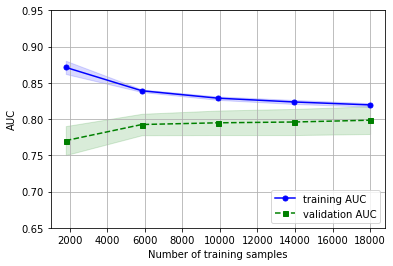

In [699]:
#Reference : https://ebookreading.net/view/book/EB9781787128576_44.html

from sklearn.model_selection import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pipe_lr = Pipeline([('scl', StandardScaler()),('clf', boosting)])



train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr,
X=X_full, y=y_full.values.ravel(), cv=10, scoring = "roc_auc")


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training AUC')


plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation AUC')

plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.ylim([0.65, 0.95])
plt.show()

#### Feature Importance

Wall time: 31 ms


Text(0.5, 1.0, 'Feature Importance')

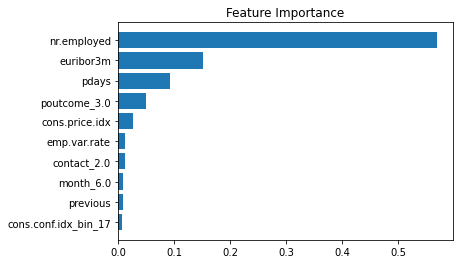

In [701]:
%%time


from sklearn.inspection import permutation_importance

# Reference: https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

#GB_fit = GB_best.fit(X_train, y_train)

sort = boosting.feature_importances_.argsort()
plt.barh(top_fs_vars[sort[::-1][:10][::-1]], boosting.feature_importances_[sort[::-1][:10][::-1]])
plt.title("Feature Importance")

## 4. Make prediction

Use the best model to make prediction on test set. Submit the result to Kaggle.

In [625]:
test_prob = pd.DataFrame(boosting.predict_proba(X_test))

In [626]:
test_prob['client_id'] = test_id
test_prob.rename(columns = {1:'subscribe'}, inplace = True)

In [627]:
kaggle_submission = test_prob[['client_id', 'subscribe']]

In [628]:
kaggle_submission

,client_id,subscribe
0,2986,0.059781
1,29710,0.045494
2,38938,0.324450
3,31313,0.100829
4,24173,0.083929
...,...,...
9995,880,0.264805
9996,28072,0.144784
9997,40491,0.050267
9998,5310,0.062245


In [629]:
kaggle_submission.to_csv("C:/Users/hhussain1/Desktop/SML/Group Project/Kaggle Uploads/submission.csv", index = False)